In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
def collect_caliberation_points():
    objp = np.zeros((9*6,3), np.float32)    
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    objpoints = []
    imgpoints = []
    
    images = glob.glob('camera_cal/calibration*.jpg')
    print(len(images))
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #return color_binary
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

objpoints, imgpoints = collect_caliberation_points()

20


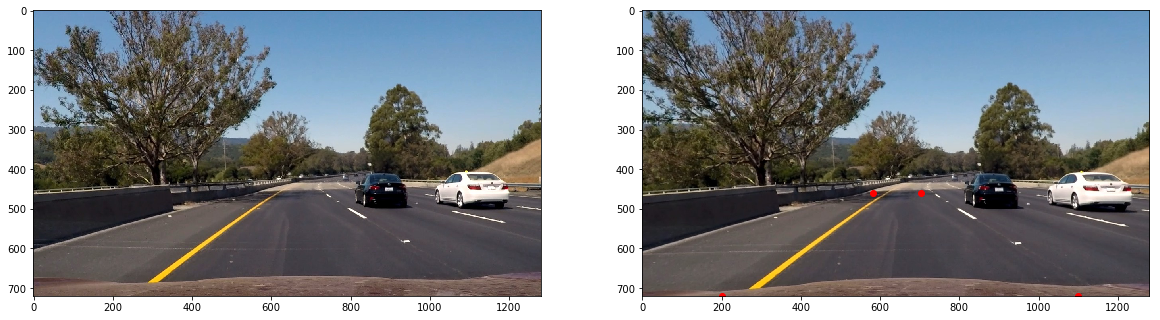

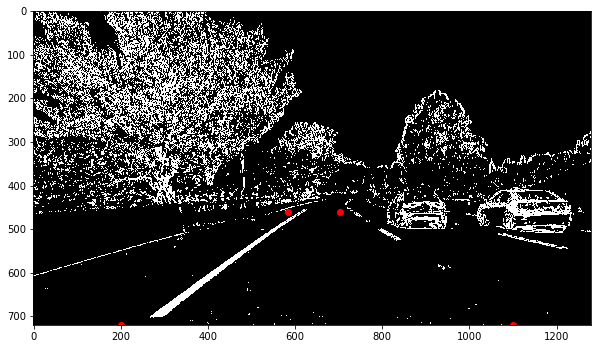

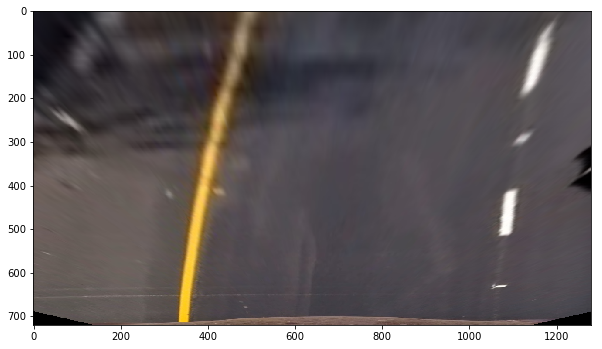

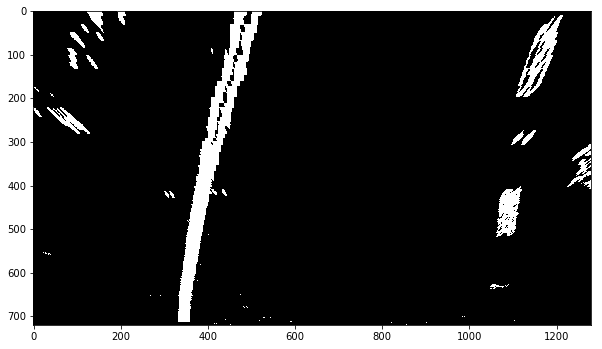

In [47]:
#img = mpimg.imread('test_images/straight_lines1.jpg')
img = mpimg.imread('test_images/test6.jpg')
#img = cv2.imread('camera_cal/calibration1.jpg')
img_size = img.shape[1], img.shape[0]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
src_points_x = [200, 583, 703, 1100]
src_points_y = [img.shape[0], 460, 460, img.shape[0]]
#ax1.plot(src_points_x, src_points_y, 'ro')
ax1.imshow(img)

dst_points_x = [300, 300, 1000, 1000]
dst_points_y = [img.shape[0],0, 0, img.shape[0]]
ax2.plot(src_points_x, src_points_y, 'ro')
ax2.imshow(undistorted)


binary = pipeline(undistorted)

plt.figure(figsize=(10,10))
plt.plot(src_points_x, src_points_y, 'ro')
plt.imshow(binary, cmap='gray')

src = np.float32(list(zip(src_points_x, src_points_y)))
dst = np.float32(list(zip(dst_points_x, dst_points_y)))
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize=(10,10))
plt.imshow(warped)

warped_binary = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize=(10,10))
plt.imshow(warped_binary, cmap='gray')


In [48]:
binary_warped = warped_binary
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

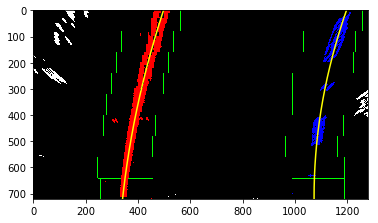

In [49]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

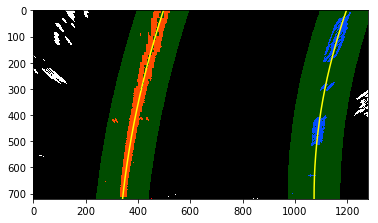

In [50]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)